# Schätzungen der Prävalenz in der Teststichprobe
Die Meldezahlen von Infektionen mit SARS-Cov2 sind abhängig von der Zahl durchgeführter Testungen.  Zudem dominieren bei geringeren tatsächlichen Infektionszahlen zunehmend falsch-positive Testungen die berichteten Zahlen.
Der Anteil wirklich infizierter Personen in der Teststichprobe (Prävalenz) ist die relevantere Größe und kann geschätzt werden auf Basis der Anzahl von Testungen, der Zahl Test-Positiver und unter Annahme der bekannten Spezifizität=89% und Sensitivität=94% des SARS-Cov2 PCR Tests. 

Basis der Analysen sind die Daten des [RKI Situationsberichts 2020-05-13](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/2020-05-13-de.pdf?__blob=publicationFile).
Punktschätzer wurden anhand von Formeln berechnet, welche die [Prävalenz aus Sensitivität und Spezifizität und der Wahrscheinlichkeit positiver Testung](https://gkappler.github.io/CausalCovid-19/Sensitivitaet_Spezifizitaet.html) herleiten.
Zudem wurde die Prävalenz Bayes-inferenzstatistisch mit einem Binomialmodell geschätzt. Bayes-Modelle ermöglichen besonders robuste Schätzungen auch bei kleinen Stichproben bzw. wenigen Test-positiven Fällen.
Die Posterior-Verteilungen der so geschätzen Prävalenz in der Teststrichprobe von Wochen <10 bis 19 werden berichtet.

**Diese Ergebnisse wurden noch nicht von Fachkollegen gegengeprüft. Wenn Sie die Methoden begutachten können, wäre ich Ihnen über kritische Rückmeldung sehr dankbar!**

In Woche 5 ergibt sich unter den 408'348 Testungen eine erwartete Zahl tatsächlich infizierter Personen von 14'922,9 Personen (vgl. mit 36'885 positiven Testungen).
In Woche 19 ergibt sich unter den 382'154 Testungen eine erwartete Zahl tatsächlich infizierter Personen von 2,3 Personen (vgl. mit 10'187 positiven Testungen).

Einschränkend ist zu sagen:
- Infektionen treten in Clustern auf. Das verwendete Modell geht aber von einer einzigen Stichprobe aus.
  **Die Testungdaten auf Landkreisebene sollten analysiert werden**.
- Sensitivität und Spezifizität müssen anhand der Quelle validiert werden. Ggf. sollten diese Parameter selbst als Zufallsvariablen mit einem informierten Prior verwendet werden.

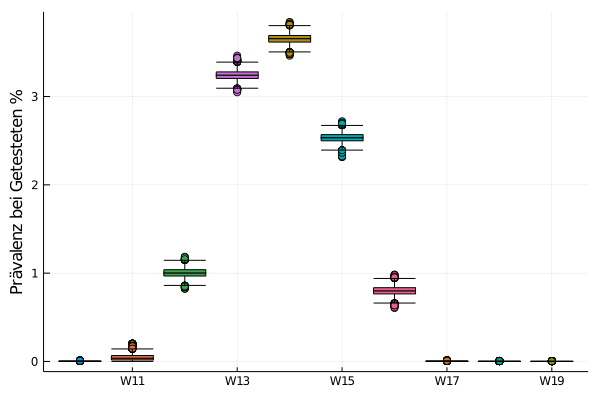

In [308]:
# Bayes Schätzer der Prävalenz bei Getesteten
function atick(i)
    "W$(data[convert(Int,i),1])"
end
p=boxplot( [ (get(chain[i],:p).p.data[:,1])*100 for i in 1:length(chain) ];legend=false,ylabel="Prävalenz bei Getesteten %",xformatter=atick)

In [295]:
# Punktschätzer der Prävalenz bei Getesteten
[ atick(i) => 100*( (data[i,3]/data[i,2]) - 1 + specificity) / (sensitivity-1+specificity) 
    for i in 1:length(chain)]

10-element Array{Pair{String,Float64},1}:
 "W-10" => -3.469047941984439  
  "W11" => -0.06183989667765042
  "W12" => 1.0032217655225282  
  "W13" => 3.2404127942832166  
  "W14" => 3.6538997389540455  
  "W15" => 2.5333378192425644  
  "W16" => 0.8000002628481477  
  "W17" => -1.207209241078149  
  "W18" => -2.5671997370621904 
  "W19" => -4.017253878159635  

In [212]:
write("pcre_test.csv","""
-10 124716 3892 (3,1%) 90
11 127457 7582 (5,9%) 114
12 348619 23820 (6,8%) 152
13 361515 31414 (8,7%) 151
14 408348 36885 (9,0%) 154
15 379233 30728 (8,1%) 163
16 330027 21993 (6,7%) 167
17 360443 18015 (5,0%) 176
18 325259 12585 (3,9%) 174
19 382154 10187 (2,7%) 173
""")
using CSV, DataFrames
data = rename!(CSV.read("pcre_test.csv", delim=" ", header=0, decimal=','), ["Woche", "Testungen","positiv","% positiv", "Labore"])

,Woche,Testungen,positiv,% positiv,Labore
,Int64,Int64,Int64,String,Int64
1,-10,124716,3892,"(3,1%)",90
2,11,127457,7582,"(5,9%)",114
3,12,348619,23820,"(6,8%)",152
4,13,361515,31414,"(8,7%)",151
5,14,408348,36885,"(9,0%)",154
6,15,379233,30728,"(8,1%)",163
7,16,330027,21993,"(6,7%)",167
8,17,360443,18015,"(5,0%)",176
9,18,325259,12585,"(3,9%)",174


In [123]:
## sensitivity, specificity = .99, .97 ## optimistic
sensitivity, specificity = .89, .94 ## published

0.005

## Bayes Schätzung der Prävalenz in Woche 5
anhand von Anzahlen von Test-Positiven, Anzahl von Testungen sowie Spezifizität und Sensitivität.

In [226]:
N_test, N_pos = data[5,2:3]

,Testungen,positiv
,Int64,Int64
5,408348,36885


In [ ]:
Anhand der Formel bedingten Wahrscheinlichkeiten 

In [227]:
( (N_pos/N_test) - 1 + specificity) / (sensitivity-1+specificity) 

0.03653899738954045

┌ Warning: `find_good_eps` is deprecated, use `find_good_stepsize` instead.
│   caller = #HMCState#52(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Type{Turing.Inference.HMCState}, ::DynamicPPL.Model{var"##inner_function#2660#172",NamedTuple{(:N_test, :y),Tuple{Int64,Int64}},DynamicPPL.ModelGen{(:N_test, :y),var"###pcretests#2674",NamedTuple{(),Tuple{}}},Val{()}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:p,),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}, ::Random._GLOBAL_RNG) at hmc.jl:552
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:552
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:553
┌ Warn

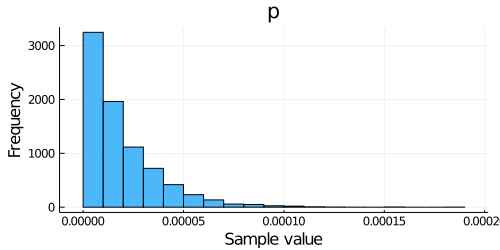

In [198]:
# Import libraries.
using Turing, StatsPlots, Random
# Declare a simple Turing binomial model.
@model pcretests(N_test,y) = begin
    # Our prior belief about the prevalence.
    p ~ Beta(1,1)
    # The total probability of a positive test
    q = p * sensitivity + (1-p) * (1-specificity)
    # The number of positive tests.
    y ~ Binomial(N_test,q)
end;

# Start sampling.
chain = sample(pcretests(N_test,N_pos), NUTS( 2000, 0.65 ), 10000);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

In [199]:
# Start sampling.
chain = [ sample(pcretests(data[i,2],data[i,3]), NUTS( 2000, 0.65 ), 10000) for i in 1:size(data)[1]];

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████

ArgumentError: ArgumentError: invalid index: :p of type Symbol

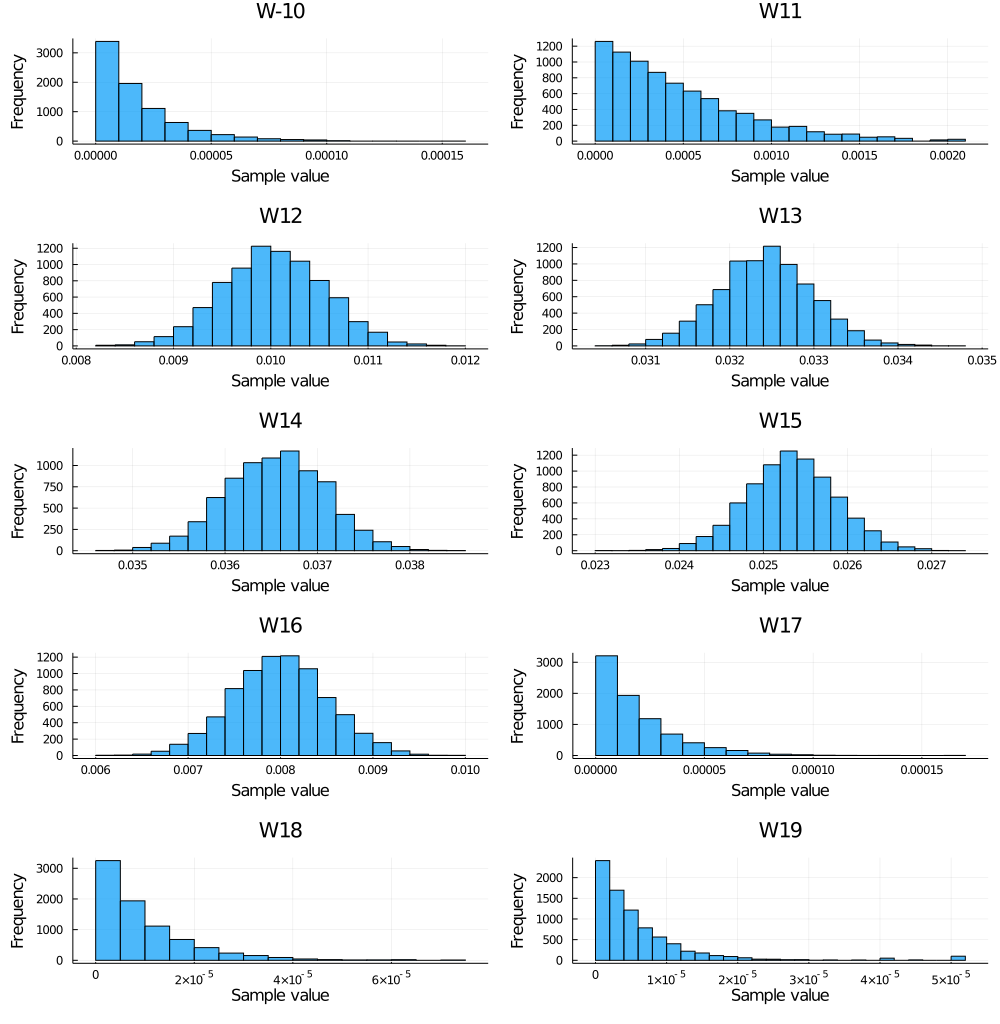

In [222]:
plot([ histogram(chain[i][:p], title="W$(data[i,1])") for i in 1:length(chain) ]..., 
        legend=false,
        layout=(5,2),
        size=(1000,1024))

In [215]:
length(chain)

10

In [306]:
i=10#length(chain)
mean(data[i,2]*get(chain[i],:p).p.data)

2.3423099771347817

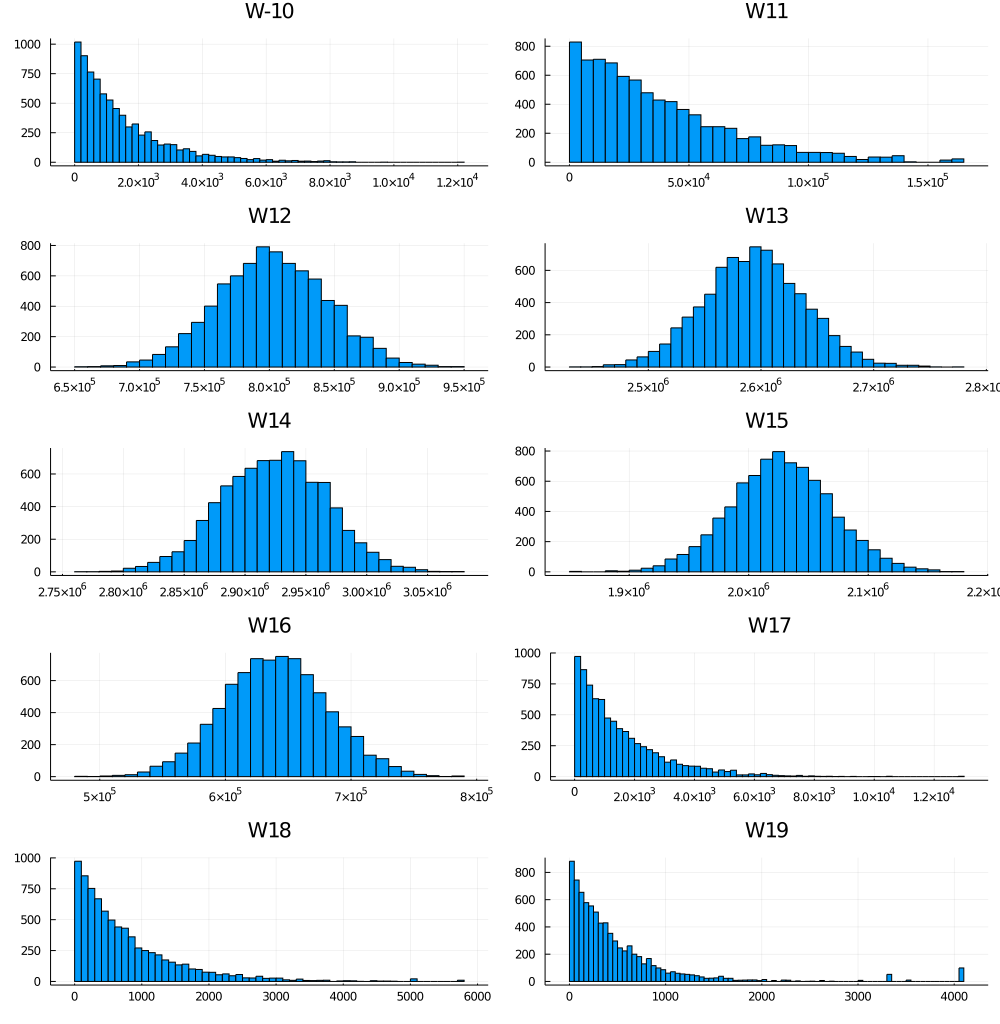

In [296]:
plot([ histogram(80*10^6*get(chain[i],:p).p.data, title="W$(data[i,1])") for i in 1:length(chain) ]..., 
        legend=false,
        layout=(5,2),
        size=(1000,1024))

In [302]:
i=7#length(chain)
mean(80*10^6*get(chain[i],:p).p.data), mean(get(chain[i],:p).p.data)

(639961.260672016, 0.007999515758400197)

In [196]:
# Declare our Turing model.
@model pcretests(y) = begin
    # Our prior belief about the probability of heads in a coin.
    M = size(y)[1]
    prevalences = tzeros(Float64,M)
    for m in 1:M
        prevalences[m] ~ Beta(1,1)#prevalence*N, N*(1-prevalence))
    end
    for i in 1:M
        # The probability of a positive test
        q = prevalences[i] * sensitivity + (1-prevalences[i]) * (1-specificity)
        # The number of positive tests.
        y[i,3] ~ Binomial(y[i,2],q)
    end
end;

# Start sampling.
chain = sample(pcretests(data), NUTS( 2000, 0.65 ), 10000);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Warning: `find_good_eps` is deprecated, use `find_good_stepsize` instead.
│   caller = #HMCState#52(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Type{Turing.Inference.HMCState}, ::DynamicPPL.Model{var"##inner_function#2633#168",NamedTuple{(:y,),Tuple{DataFrame}},DynamicPPL.ModelGen{(:y,),var"###pcretests#2647",NamedTuple{(),Tuple{}}},Val{()}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:prevalences,),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:prevalences},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:prevalences},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}, ::Random._GLOBAL_RNG) at hmc.jl:552
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:552


TypeError: TypeError: in typeassert, expected Float64, got ForwardDiff.Dual{Nothing,Float64,10}

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


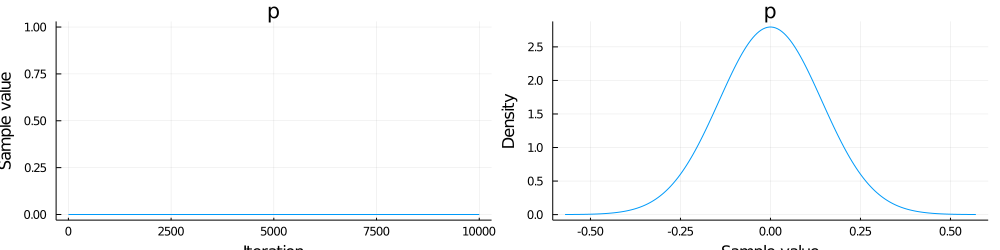

In [190]:
chain = sample(pcretests(N_pos), HMC( 0.01,100), 10000);
plot(chain)


In [164]:
?CSV.File

```
CSV.File(source; kwargs...) => CSV.File
```

Read a UTF-8 CSV input (a filename given as a String or FilePaths.jl type, or any other IO source), returning a `CSV.File` object.

Opens the file and uses passed arguments to detect the number of columns and column types, unless column types are provided manually via the `types` keyword argument. Note that passing column types manually can increase performance and reduce the memory use for each column type provided (column types can be given as a `Vector` for all columns, or specified per column via name or index in a `Dict`). For text encodings other than UTF-8, see the [StringEncodings.jl](https://github.com/JuliaStrings/StringEncodings.jl) package for re-encoding a file or IO stream. The returned `CSV.File` object supports the [Tables.jl](https://github.com/JuliaData/Tables.jl) interface and can iterate `CSV.Row`s. `CSV.Row` supports `propertynames` and `getproperty` to access individual row values. `CSV.File` also supports entire column access like a `DataFrame` via direct property access on the file object, like `f = CSV.File(file); f.col1`. Note that duplicate column names will be detected and adjusted to ensure uniqueness (duplicate column name `a` will become `a_1`). For example, one could iterate over a csv file with column names `a`, `b`, and `c` by doing:

```julia
for row in CSV.File(file)
    println("a=$(row.a), b=$(row.b), c=$(row.c)")
end
```

By supporting the Tables.jl interface, a `CSV.File` can also be a table input to any other table sink function. Like:

```julia
# materialize a csv file as a DataFrame, without copying columns from CSV.File; these columns are read-only
df = CSV.File(file) |> DataFrame!

# load a csv file directly into an sqlite database table
db = SQLite.DB()
tbl = CSV.File(file) |> SQLite.load!(db, "sqlite_table")
```

Supported keyword arguments include:

  * File layout options:

      * `header=1`: the `header` argument can be an `Int`, indicating the row to parse for column names; or a `Range`, indicating a span of rows to be concatenated together as column names; or an entire `Vector{Symbol}` or `Vector{String}` to use as column names; if a file doesn't have column names, either provide them as a `Vector`, or set `header=0` or `header=false` and column names will be auto-generated (`Column1`, `Column2`, etc.)
      * `normalizenames=false`: whether column names should be "normalized" into valid Julia identifier symbols; useful when iterating rows and accessing column values of a row via `getproperty` (e.g. `row.col1`)
      * `datarow`: an `Int` argument to specify the row where the data starts in the csv file; by default, the next row after the `header` row is used. If `header=0`, then the 1st row is assumed to be the start of data
      * `skipto::Int`: similar to `datarow`, specifies the number of rows to skip before starting to read data
      * `footerskip::Int`: number of rows at the end of a file to skip parsing
      * `limit`: an `Int` to indicate a limited number of rows to parse in a csv file; use in combination with `skipto` to read a specific, contiguous chunk within a file
      * `transpose::Bool`: read a csv file "transposed", i.e. each column is parsed as a row
      * `comment`: rows that begin with this `String` will be skipped while parsing
      * `use_mmap::Bool=!Sys.iswindows()`: whether the file should be mmapped for reading, which in some cases can be faster
      * `ignoreemptylines::Bool=false`: whether empty rows/lines in a file should be ignored (if `false`, each column will be assigned `missing` for that empty row)
      * `threaded::Bool`: whether parsing should utilize multiple threads; by default threads are used on large enough files, but isn't allowed when `transpose=true` or when `limit` is used; only available in Julia 1.3+
      * `select`: an `AbstractVector` of `Int`, `Symbol`, `String`, or `Bool`, or a "selector" function of the form `(i, name) -> keep::Bool`; only columns in the collection or for which the selector function returns `true` will be parsed and accessible in the resulting `CSV.File`. Invalid values in `select` are ignored.
      * `drop`: inverse of `select`; an `AbstractVector` of `Int`, `Symbol`, `String`, or `Bool`, or a "drop" function of the form `(i, name) -> drop::Bool`; columns in the collection or for which the drop function returns `true` will ignored in the resulting `CSV.File`. Invalid values in `drop` are ignored.
  * Parsing options:

      * `missingstrings`, `missingstring`: either a `String`, or `Vector{String}` to use as sentinel values that will be parsed as `missing`; by default, only an empty field (two consecutive delimiters) is considered `missing`
      * `delim=','`: a `Char` or `String` that indicates how columns are delimited in a file; if no argument is provided, parsing will try to detect the most consistent delimiter on the first 10 rows of the file
      * `ignorerepeated::Bool=false`: whether repeated (consecutive) delimiters should be ignored while parsing; useful for fixed-width files with delimiter padding between cells
      * `quotechar='"'`, `openquotechar`, `closequotechar`: a `Char` (or different start and end characters) that indicate a quoted field which may contain textual delimiters or newline characters
      * `escapechar='"'`: the `Char` used to escape quote characters in a quoted field
      * `dateformat::Union{String, Dates.DateFormat, Nothing}`: a date format string to indicate how Date/DateTime columns are formatted for the entire file
      * `decimal='.'`: a `Char` indicating how decimals are separated in floats, i.e. `3.14` used '.', or `3,14` uses a comma ','
      * `truestrings`, `falsestrings`: `Vectors of Strings` that indicate how `true` or `false` values are represented; by default only `true` and `false` are treated as `Bool`
  * Column Type Options:

      * `type`: a single type to use for parsing an entire file; i.e. all columns will be treated as the same type; useful for matrix-like data files
      * `types`: a Vector or Dict of types to be used for column types; a Dict can map column index `Int`, or name `Symbol` or `String` to type for a column, i.e. Dict(1=>Float64) will set the first column as a Float64, Dict(:column1=>Float64) will set the column named column1 to Float64 and, Dict("column1"=>Float64) will set the column1 to Float64; if a `Vector` if provided, it must match the # of columns provided or detected in `header`
      * `typemap::Dict{Type, Type}`: a mapping of a type that should be replaced in every instance with another type, i.e. `Dict(Float64=>String)` would change every detected `Float64` column to be parsed as `String`
      * `pool::Union{Bool, Float64}=0.1`: if `true`, *all* columns detected as `String` will be internally pooled; alternatively, the proportion of unique values below which `String` columns should be pooled (by default 0.1, meaning that if the # of unique strings in a column is under 10%, it will be pooled)
      * `categorical::Bool=false`: whether pooled columns should be copied as CategoricalArray instead of PooledArray; note that in `CSV.read`, by default, columns are not copied, so pooled columns will have type `CSV.Column{String, PooledString}`; to get `CategoricalArray` columns, also pass `copycols=true`
      * `strict::Bool=false`: whether invalid values should throw a parsing error or be replaced with `missing`
      * `silencewarnings::Bool=false`: if `strict=false`, whether invalid value warnings should be silenced


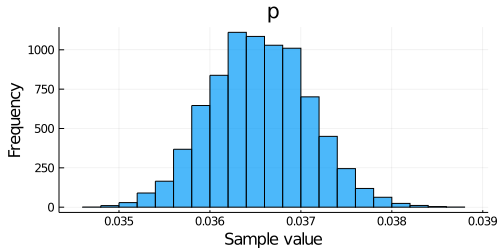

In [159]:
histogram(chain[:p])

In [59]:
?HMC

search: HMC HMCDA SGHMC eachmatch Hypergeometric NoncentralHypergeometric



```
HMC(ϵ::Float64, n_leapfrog::Int)
```

Hamiltonian Monte Carlo sampler with static trajectory.

Arguments:

  * `ϵ::Float64` : The leapfrog step size to use.
  * `n_leapfrog::Int` : The number of leapfrop steps to use.

Usage:

```julia
HMC(0.05, 10)
```

Tips:

  * If you are receiving gradient errors when using `HMC`, try reducing the

`step_size` parameter, e.g.

```julia
# Original step_size
sample(gdemo([1.5, 2]), HMC(0.1, 10), 1000)

# Reduced step_size.
sample(gdemo([1.5, 2]), HMC(0.01, 10), 1000)
```


In [138]:

# Set the true probability of heads in a coin.
p_true = prevalence

# Iterate from having seen 0 observations to 100 observations.

# Draw data from a Binomial distribution, i.e. draw N .
Random.seed!(13)
data = vcat([ 1 for _ in 1:N_pos ],[ 0 for _ in 1:(N_test-N_pos) ])
# Declare our Turing model.
@model pcretests(M,y) = begin
    # Our prior belief about the probability of heads in a coin.
    prevalences = tzeros(Float64,M)
    for m in 1:M
        prevalences[m] ~ Beta(1,1)#prevalence*N, N*(1-prevalence))
    end
    group = tzeros(Int,length(y))
    ps ~ Dirichlet(ones(M))
    for i in 1:N_test
        group[i] = rand(Categorical(ps))
        p = prevalences[group[i]]
        q = p * sensitivity + (1-p) * (1-specificity)
        y[i] ~ Bernoulli(q)
    end
end;

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 100000
ϵ = 0.05
τ = 10

# Start sampling.
chain = sample(pcretests(2,data), NUTS( 0.65), iterations);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Warning: `find_good_eps` is deprecated, use `find_good_stepsize` instead.
│   caller = #HMCState#52(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Type{Turing.Inference.HMCState}, ::DynamicPPL.Model{var"##inner_function#2293#144",NamedTuple{(:M, :y),Tuple{Int64,Array{Int64,1}}},DynamicPPL.ModelGen{(:M, :y),var"###pcretests#2313",NamedTuple{(),Tuple{}}},Val{()}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:prevalences, :ps),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:prevalences},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:prevalences},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ps},Int64},Array{Dirichlet{Float64},1},Array{DynamicPPL.VarName{:ps},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}, ::Random._GLOBAL_RNG) at hmc.jl:552
└ @ Turing.Inference /home/

TypeError: TypeError: in typeassert, expected Float64, got ForwardDiff.Dual{Nothing,Float64,4}

In [140]:
?Bernoulli

search: Bernoulli



```
Bernoulli(p)
```

A *Bernoulli distribution* is parameterized by a success rate `p`, which takes value 1 with probability `p` and 0 with probability `1-p`.

$$
P(X = k) = \begin{cases}
1 - p & \quad \text{for } k = 0, \\
p & \quad \text{for } k = 1.
\end{cases}
$$

```julia
Bernoulli()    # Bernoulli distribution with p = 0.5
Bernoulli(p)   # Bernoulli distribution with success rate p

params(d)      # Get the parameters, i.e. (p,)
succprob(d)    # Get the success rate, i.e. p
failprob(d)    # Get the failure rate, i.e. 1 - p
```

External links:

  * [Bernoulli distribution on Wikipedia](http://en.wikipedia.org/wiki/Bernoulli_distribution)


In [134]:


# Declare our Turing model.
@model pcretests(y) = begin
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(1, 1)

    # The number of observations.
    infected ~ Binomial(N,p)
    true_pos ~ Binomial(infected,sensitivity)
    false_pos ~ Binomial(N-infected,1-specificity)
    y = true_pos + false_pos
end;

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

# Start sampling.
chain = sample(pcretests(data), NUTS(0.65), iterations);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Warning: `find_good_eps` is deprecated, use `find_good_stepsize` instead.
│   caller = #HMCState#52(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Type{Turing.Inference.HMCState}, ::DynamicPPL.Model{var"##inner_function#2170#130",NamedTuple{(:y,),Tuple{Int64}},DynamicPPL.ModelGen{(:y,),var"###pcretests#2196",NamedTuple{(),Tuple{}}},Val{()}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},A

MethodError: MethodError: no method matching _logpdf_with_trans(::Binomial{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"##inner_function#2170#130",NamedTuple{(:y,),Tuple{Int64}},DynamicPPL.ModelGen{(:y,),var"###pcretests#2196",NamedTuple{(),Tuple{}}},Val{()}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}},Float64},Float64,4}}, ::ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"##inner_function#2170#130",NamedTuple{(:y,),Tuple{Int64}},DynamicPPL.ModelGen{(:y,),var"###pcretests#2196",NamedTuple{(),Tuple{}}},Val{()}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}},Float64},Float64,4}, ::Bool)
Closest candidates are:
  _logpdf_with_trans(!Matched::Union{Kolmogorov, BetaPrime, Chi, Chisq, Erlang, Exponential, FDist, Frechet, Gamma, InverseGamma, InverseGaussian, LogNormal, NoncentralChisq, NoncentralF, Rayleigh, Weibull}, ::Real, ::Bool) at /home/gregor/.julia/packages/Bijectors/kgZvw/src/Bijectors.jl:232
  _logpdf_with_trans(!Matched::Union{KSOneSided, Beta, NoncentralBeta}, ::Real, ::Bool) at /home/gregor/.julia/packages/Bijectors/kgZvw/src/Bijectors.jl:245
  _logpdf_with_trans(!Matched::Union{Truncated{T,S,T1} where T1<:Real where S<:ValueSupport, T} where T<:Distribution{Univariate,Continuous}, ::Real, ::Bool) at /home/gregor/.julia/packages/Bijectors/kgZvw/src/Bijectors.jl:204

In [5]:
using Pkg
Pkg.add("MCMCChains")

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
  [c7f686f2] + MCMCChains v3.0.12
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
